In [1]:
%matplotlib widget 
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import neurobayes as nb
import gpax

from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import numpy as np
import string 

plt.style.use('seaborn-v0_8-bright')
palette = 'winter'

myrcparams = {
    'axes.labelsize': 20,
    'axes.titlesize': 18,
    'legend.fontsize': 14,
    'legend.title_fontsize':20,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    #'figure.autolayout': True,
}
plt.rcParams.update(myrcparams)

import jax
jax.config.update("jax_enable_x64", True)

# Read in data

In [2]:
df = pd.read_csv('history.csv', index_col=0).dropna()
df

,Cu,NaOH,median_ratio,fit_B,fit_A,fit_C
12,100.0,7.5,1.061765,0.863411,0.111075,1.540008
13,125.0,7.5,1.079406,0.913015,0.151946,1.614611
14,150.0,7.5,1.076986,0.823122,0.162740,1.802661
15,175.0,7.5,1.026320,1.000000,0.050074,1.877772
16,200.0,7.5,1.055157,0.917538,0.112666,1.877772
...,...,...,...,...,...,...
283,275.0,24.0,1.045752,1.543464,0.005812,0.586938
284,300.0,24.0,1.030849,1.519380,0.004675,0.529264
285,325.0,24.0,1.048951,1.822308,0.003292,0.659164
286,350.0,24.0,1.034483,1.774114,0.002309,0.520146


In [3]:
X = df[ ['Cu', 'NaOH'] ]
targets = {'median_ratio':'Median ratio', 'fit_A':r'$A_{fit}$', 'fit_B':r'$B_{fit}$', 'fit_C':r'$C_{fit}$'}
Y = df[ targets.keys() ]

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

# Random forest, Gaussian processes, and MLP

In [5]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-2)
models = {'rf': RandomForestRegressor(), 'gp': GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10), 
          'mlp': MLPRegressor(hidden_layer_sizes=[64], learning_rate_init=5e-3, max_iter=1000)}

X_kscaler, y_kscaler = StandardScaler(), StandardScaler()
acc_dfs = []
y_preds_dfs = {model_name: {} for model_name, model in models.items()}
for model_name, model in models.items():
    
    acc_arr = np.zeros( (4, len(targets)) )
    y_preds_arr = np.zeros( (len(X_train), len(targets) ) )

    for i, (target, target_label) in enumerate(targets.items()):
         
        y_train = Y_train[target]
        
        rmse_folds, r2_folds = [], []
        
        for train_inds, test_inds in kf.split(X_train):

            X_ktrain = X_train.iloc[train_inds,:]
            X_ktest = X_train.iloc[test_inds, :]
            X_kscaler.fit(X_ktrain)
            X_ktrain_scaled = X_kscaler.transform(X_ktrain)
            X_ktest_scaled = X_kscaler.transform(X_ktest)

            y_ktrain = y_train.iloc[train_inds].to_numpy()
            y_ktest = y_train.iloc[test_inds].to_numpy()
            y_kscaler.fit(y_ktrain.reshape(-1, 1))
            y_ktrain_scaled = y_kscaler.transform( y_ktrain.reshape(-1, 1) ).reshape( y_ktrain.shape )
            y_ktest_scaled = y_kscaler.transform( y_ktest.reshape(-1, 1) ).reshape( y_ktest.shape )

            model.fit(X_ktrain_scaled, y_ktrain_scaled)

            y_kpred_scaled = model.predict(X_ktest_scaled)
            y_kpred = y_kscaler.inverse_transform( y_kpred_scaled.reshape(-1,1) )
                
            rmse_folds.append( np.sqrt(mean_squared_error(y_ktest, y_kpred)) )
            r2_folds.append( r2_score(y_ktest, y_kpred) )

            y_preds_arr[test_inds, i] = y_kpred.reshape( (y_kpred.shape[0],) )
        
        acc_arr[0,i] = np.mean(rmse_folds)
        acc_arr[1,i] = np.std(rmse_folds)
        acc_arr[2,i] = np.mean(r2_folds)
        acc_arr[3,i] = np.std(r2_folds)

    acc_df = pd.DataFrame(acc_arr, columns = targets)
    acc_df.insert(0, 'model', [model_name]*len(acc_df))
    acc_df.index = ['rmse_mean', 'rmse_std', 'r2_mean', 'r2_std']
    acc_dfs.append( acc_df )

    y_preds_df = pd.DataFrame(y_preds_arr, columns = targets.keys())
    y_preds_dfs[model_name] = y_preds_df

/Users/alle927/miniconda3/envs/neq_rxt_scalarize/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/alle927/miniconda3/envs/neq_rxt_scalarize/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/alle927/miniconda3/envs/neq_rxt_scalarize/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alle927/miniconda3/envs/neq_rxt_scala

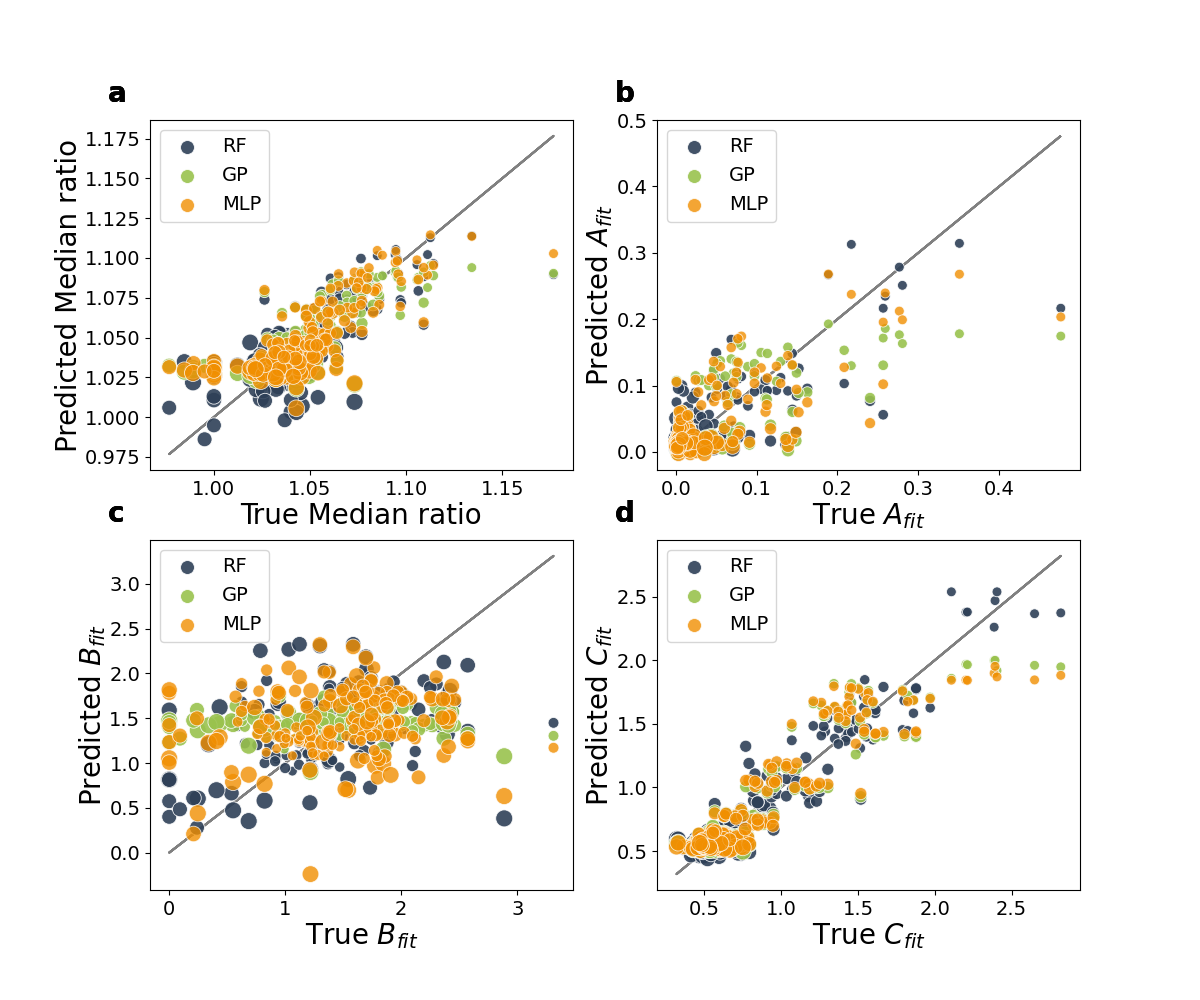

In [6]:
colors = ['#2e4057', '#99c24d', '#f18f01', '#048ba8']
markers = ['s', '^', 'd', 'o']
markersizes = [100, 90, 80, 70]
alphas = [0.9, 0.9, 0.8, 0.6]

fig,axes = plt.subplots(2, 2, figsize=(12.0, 10.0))
for j, (model_name, model) in enumerate(models.items()):

    for i,target in enumerate(targets):
        y_true = Y_train[target].reset_index(drop=True)
        y_pred = y_preds_dfs[model_name][target]
        naoh = X_train['NaOH'].reset_index(drop=True)
        
        df_to_plot = pd.DataFrame( [y_true, y_pred, naoh] ).T
        df_to_plot.columns = ['y_true', 'y_pred', 'NaOH']
        axes[i//2, i%2].plot(y_true, y_true, '-', color='gray', zorder=1)
        sns.scatterplot(data=df_to_plot, x='y_true', y='y_pred', color=colors[j], size='NaOH', ax=axes[i//2, i%2], sizes=(50, 150), alpha=alphas[j], legend=False, label=model_name.upper(), zorder=3)
        axes[i//2, i%2].set_xlabel('True '+targets[target])
        axes[i//2, i%2].set_ylabel(f'Predicted '+targets[target])
        axes[i//2, i%2].xaxis.labelpad = 2
        axes[i//2, i%2].yaxis.labelpad = 1
        axes[i//2, i%2].legend()

        axes[i//2, i%2].text(-0.1, 1.05, f'{string.ascii_lowercase[i]}', transform=axes[i//2, i%2].transAxes, 
            size=20, fontweight='bold')
fig.savefig(f"parity_nonprob.png", dpi=600)

            

# Bayesian models

In [7]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

bnn_net = nb.FlaxMLP(hidden_dims=[32], target_dim=1)
pbnn_net = nb.FlaxMLP(hidden_dims=[4, 4], target_dim=1)
rng_key_train, rng_key_predict = gpax.utils.get_keys()
models = {'bnn': nb.BNN(bnn_net), 'pbnn': nb.PartialBNN(pbnn_net, probabilistic_layer_names='Dense0') }
#          'bgp': gpax.ExactGP(X.shape[-1], kernel='Matern') }

X_kscaler, y_kscaler = StandardScaler(), StandardScaler()
acc_dfs = {model_name: {} for model_name, model in models.items()}
y_preds_dfs = {model_name: {} for model_name, model in models.items()}
unc_preds_dfs = {model_name: {} for model_name, model in models.items()}
for model_name, model in models.items():

        acc_arr = np.zeros( (8, len(targets)) )
        y_preds_arr = np.zeros( (len(X_train), len(targets) ) )
        unc_preds_arr = np.zeros( (len(X_train), len(targets) ) )
        for i,(target, target_label) in enumerate(targets.items()):
            
            y_train = Y_train[target]

            rmse_folds, r2_folds, nlpd_folds, cov_folds = [], [], [], []
            
            for train_inds, test_inds in kf.split(X_train):
                
                X_ktrain = X_train.iloc[train_inds,:]
                X_ktest = X_train.iloc[test_inds, :]
                X_kscaler.fit(X_ktrain)
                X_ktrain_scaled = X_kscaler.transform(X_ktrain)
                X_ktest_scaled = X_kscaler.transform(X_ktest)

                y_ktrain = y_train.iloc[train_inds].to_numpy()
                y_ktest = y_train.iloc[test_inds].to_numpy()
                y_kscaler.fit(y_ktrain.reshape(-1, 1))
                y_ktrain_scaled = y_kscaler.transform( y_ktrain.reshape(-1, 1) ).reshape( y_ktrain.shape )
                y_ktest_scaled = y_kscaler.transform( y_ktest.reshape(-1, 1) ).reshape( y_ktest.shape )

                model.fit(X = X_ktrain_scaled, y = y_ktrain_scaled, num_warmup=1000, num_samples=1000, rng_key=rng_key_train) 
 
                if model_name == 'bgp':
                    y_kpred_scaled, unc_kpred_scaled = model.predict(X_new=X_ktest_scaled, n = 200, rng_key=rng_key_predict)
                else:
                    y_kpred_scaled, unc_kpred_scaled = model.predict(X_new=X_ktest_scaled, rng_key=rng_key_predict)

                y_kpred = y_kscaler.inverse_transform( y_kpred_scaled.reshape(-1,1) )

                if model_name == 'bgp':
                    unc_kpred_scaled =  unc_kpred_scaled.std(axis=(0,1))
                unc_kpred = y_kscaler.inverse_transform( unc_kpred_scaled.reshape(-1,1) ) 

                rmse_folds.append( np.sqrt(mean_squared_error(y_ktest, y_kpred)) )
                r2_folds.append( r2_score(y_ktest, y_kpred) )
                nlpd_folds.append( nb.utils.nlpd(y_ktest, y_kpred, unc_kpred) )
                cov_folds.append( nb.utils.coverage(y_ktest, y_kpred, unc_kpred) )

                y_preds_arr[test_inds, i] = y_kpred.reshape( (y_kpred.shape[0],) )
                unc_preds_arr[test_inds, i] = unc_kpred.reshape( (unc_kpred.shape[0],) )
            
            acc_arr[0,i] = np.mean(rmse_folds)
            acc_arr[1,i] = np.std(rmse_folds)
            acc_arr[2,i] = np.mean(r2_folds)
            acc_arr[3,i] = np.std(r2_folds)
            acc_arr[4,i] = np.mean(nlpd_folds)
            acc_arr[5,i] = np.std(nlpd_folds)
            acc_arr[6,i] = np.mean(cov_folds)
            acc_arr[7,i] = np.std(cov_folds)

        acc_df = pd.DataFrame(acc_arr, columns = targets)
        acc_df.insert(0, 'model', [model_name]*len(acc_df))
        acc_df.index = ['rmse_mean', 'rmse_std', 'r2_mean', 'r2_std', 'nlpd_mean', 'nlpd_std', 'cov_mean', 'cov_std']
        acc_dfs[model_name] = acc_df

        y_preds_df = pd.DataFrame(y_preds_arr, columns = targets)
        y_preds_dfs[model_name]= y_preds_df

        unc_preds_df = pd.DataFrame(unc_preds_arr, columns = targets)
        unc_preds_dfs[model_name] = unc_preds_df

sample: 100%|██████████| 2000/2000 [00:38<00:00, 51.33it/s, 511 steps of size 6.95e-03. acc. prob=0.91] 


Training deterministic NN...


Training Progress: 100%|██████████| 500/500 [00:00<00:00, 1103.12it/s, Epoch 500/500, LR: 0.010000, Loss: 0.3736 ]


Training partially Bayesian NN


sample: 100%|██████████| 2000/2000 [00:02<00:00, 807.58it/s, 63 steps of size 4.62e-02. acc. prob=0.92]  


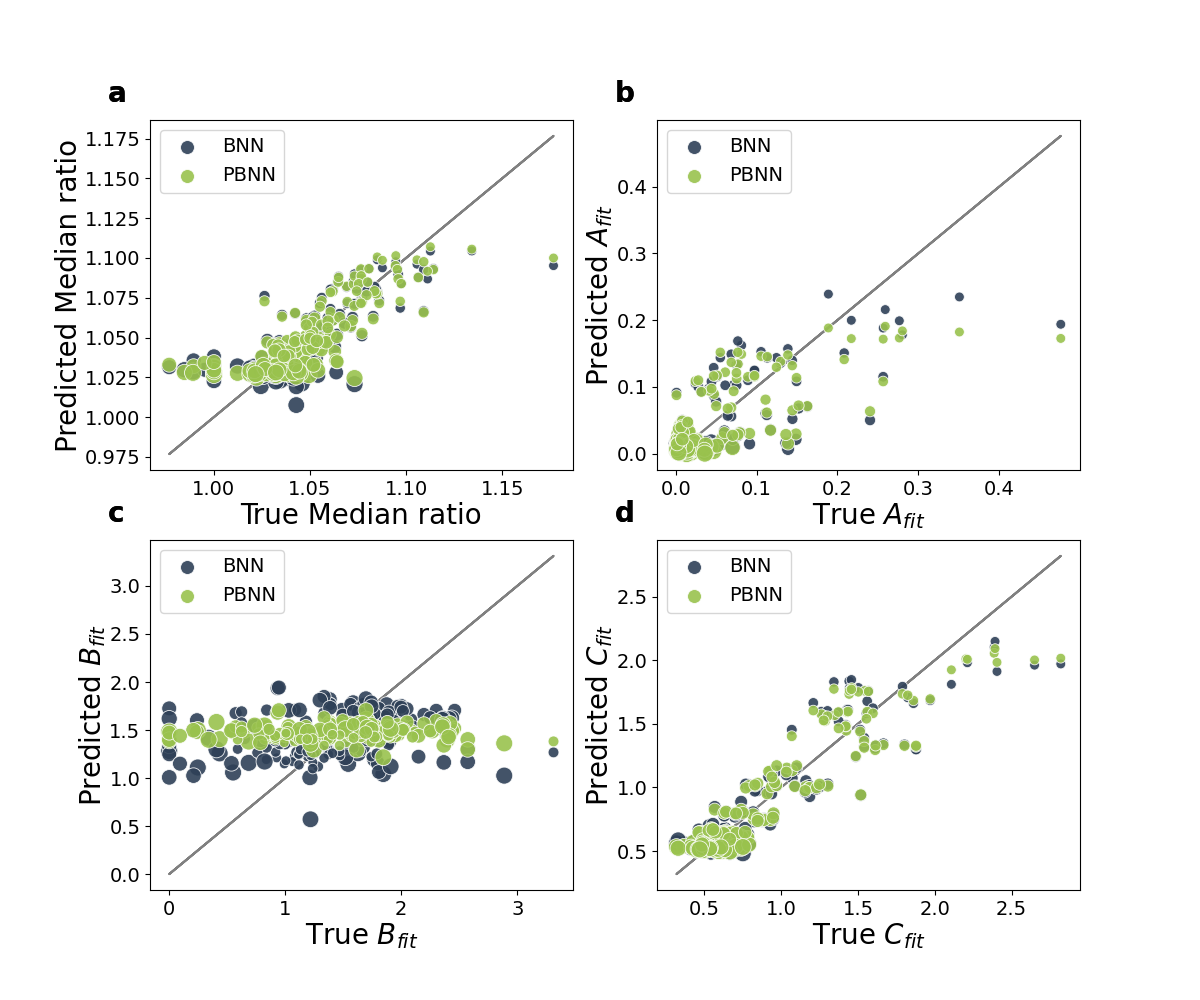

In [9]:
colors = ['#2e4057', '#99c24d', '#f18f01', '#048ba8']
markers = ['s', '^', 'd', 'o']
markersizes = [100, 90, 80, 70]
alphas = [0.9, 0.9, 0.8, 0.6]

fig,axes = plt.subplots(2, 2, figsize=(12.0, 10.0))
for j, (model_name, model) in enumerate(models.items()):

    for i,target in enumerate(targets):
        y_true = Y_train[target].reset_index(drop=True)
        y_pred = y_preds_dfs[model_name][target]
        unc_pred = unc_preds_dfs[model_name][target]
        naoh = X_train['NaOH'].reset_index(drop=True)
        
        df_to_plot = pd.DataFrame( [y_true, y_pred, unc_pred, naoh] ).T
        df_to_plot.columns = ['y_true', 'y_pred', 'unc_pred', 'NaOH']
        axes[i//2, i%2].plot(y_true, y_true, '-', color='gray', zorder=1)
        sns.scatterplot(data=df_to_plot, x='y_true', y='y_pred', color=colors[j], size='NaOH', ax=axes[i//2, i%2], sizes=(50, 150), alpha=alphas[j], legend=False, label=model_name.upper(), zorder=3)
        
        axes[i//2, i%2].set_xlabel('True '+targets[target])
        axes[i//2, i%2].set_ylabel(f'Predicted '+targets[target])
        axes[i//2, i%2].xaxis.labelpad = 2
        axes[i//2, i%2].yaxis.labelpad = 1
        axes[i//2, i%2].legend()

        axes[i//2, i%2].text(-0.1, 1.05, f'{string.ascii_lowercase[i]}', transform=axes[i//2, i%2].transAxes, 
            size=20, fontweight='bold')
fig.savefig(f"parity_prob.png", dpi=600)